In [1]:
# Import necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import normaltest

In [2]:
# Upload data from csv's
df_2015 = pd.read_csv('..\Data\pitches_2015.csv', index_col = 'game_id')
df_2016 = pd.read_csv('..\Data\pitches_2016.csv', index_col = 'game_id')
df_2017 = pd.read_csv('..\Data\pitches_2017.csv', index_col = 'game_id')

# Combine all seasonal dataframes into one
df = pd.concat([df_2015, df_2016, df_2017])

# Drop 'Unnamed' column
df.drop('Unnamed: 0', axis = 1, inplace = True)

### Remove All-Star Games

Each of the csv's above contain every regular season game from their respective seasons including All-Star Games. The All-Star Game splits the best players in the league into two teams and the outcome of the game has no impact on the regular season. The game also isn't played like a regular season game. Players could get swapped out every inning regardless of fatigue or performance and for those reasons, I'll be removing these games. The corresponding game_id for the All-Star games are below.

In [3]:
all_star_gameid = [414988, 448202, 491434]

for i in all_star_gameid:
    df.drop(i, inplace=True)
df.reset_index(inplace=True)

# View head of df
df.head()

,game_id,batSide_code,batSide_des,batter,batter_id,call,call_des,count_balls,count_strikes,inning_num,inning_top_bot,pitchHand_code,pitchHand_des,pitch_locx,pitch_locy,pitch_speed,pitch_type,pitch_type_des,pitcher,pitcher_id
0,413661,L,Left,Matt Carpenter,572761,C,Called Strike,0,0,1,top,L,Left,0.416,2.963,92.9,FF,Four-Seam Fastball,Jon Lester,452657
1,413661,L,Left,Matt Carpenter,572761,S,Swinging Strike,0,1,1,top,L,Left,-0.191,2.347,92.8,FF,Four-Seam Fastball,Jon Lester,452657
2,413661,L,Left,Matt Carpenter,572761,F,Foul,0,2,1,top,L,Left,-0.518,3.284,94.1,FF,Four-Seam Fastball,Jon Lester,452657
3,413661,L,Left,Matt Carpenter,572761,B,Ball,0,2,1,top,L,Left,-0.641,1.221,91.0,FF,Four-Seam Fastball,Jon Lester,452657
4,413661,L,Left,Matt Carpenter,572761,B,Ball,1,2,1,top,L,Left,-1.821,2.083,75.4,CU,Curveball,Jon Lester,452657


In [4]:
df.describe()

,game_id,batter_id,count_balls,count_strikes,inning_num,pitch_locx,pitch_locy,pitch_speed,pitcher_id
count,2.134073e+06,2.134073e+06,2.134073e+06,2.134073e+06,2.134073e+06,2.134073e+06,2.134073e+06,2.129466e+06,2.134073e+06
mean,4.518092e+05,5.099545e+05,8.796077e-01,8.800168e-01,4.997819e+00,2.329170e-01,2.589080e+00,8.830204e+01,5.182730e+05
std,3.129214e+04,8.181368e+04,9.651697e-01,8.248188e-01,2.664939e+00,5.419492e+00,7.331222e+00,6.048753e+00,7.672827e+04
min,4.136610e+05,1.125260e+05,0.000000e+00,0.000000e+00,1.000000e+00,-1.054333e+01,-5.183664e+00,3.390000e+01,1.125260e+05
25%,4.155160e+05,4.559760e+05,0.000000e+00,0.000000e+00,3.000000e+00,-6.010000e-01,1.656000e+00,8.430000e+01,4.585840e+05
50%,4.481210e+05,5.185950e+05,1.000000e+00,1.000000e+00,5.000000e+00,6.000000e-03,2.263467e+00,8.970000e+01,5.191410e+05
75%,4.907290e+05,5.721140e+05,1.000000e+00,2.000000e+00,7.000000e+00,6.064463e-01,2.868000e+00,9.290000e+01,5.807920e+05
max,4.925280e+05,6.697200e+05,4.000000e+00,2.000000e+00,1.900000e+01,2.472733e+02,2.472400e+02,1.050000e+02,6.647010e+05


### Clean ``call`` column

In columns ``call`` and ``call_des``, there are a multitude of values that these columns can take. Each code in the ``call`` columns should correspond to a description as to what happened during the play. It'll be useful to understand what each of the codes mean.

In [5]:
# Determine what the call codes mean by sorting by code and description
call_codes = df.dropna().groupby('call')['call_des'].unique()
print(call_codes)

call
*B                 [Ball In Dirt]
B                          [Ball]
C                 [Called Strike]
D               [In play, no out]
E               [In play, run(s)]
F     [Foul, Foul (Runner Going)]
I                   [Intent Ball]
L                     [Foul Bunt]
M                   [Missed Bunt]
P                      [Pitchout]
Q             [Swinging Pitchout]
R                 [Foul Pitchout]
S               [Swinging Strike]
T                      [Foul Tip]
W     [Swinging Strike (Blocked)]
X               [In play, out(s)]
Z               [In play, run(s)]
Name: call_des, dtype: object


As printed in the above output, there are multiple codes that could mean the same thing in regards to the outcome of a pitch. For example, ``Ball in Dirt`` and ``Intent Ball`` could simply mean ``Ball``. The codes could therefore be simplified to mean the same things. However ``W``(``Swinging Strike (Blocked)``) poses an interesting problem. When a batter swings at a ball in the dirt and misses with 2 strikes, the batter as the option to run to first base. If he successfully makes it to first, he's considered safe. It counts as a a strikeout for the pitcher but not an official out during the game. To help simplify the codes, consider how many times ``W`` occured with 2 strikes and standardizing the outcome to strikes if it'll have minimal effect.

In [6]:
# Count how many 'W' with 2 strikes
swinging_strike_blocked = df[(df['call'] == 'W') & (df['count_strikes'] == 2)]
print(len(swinging_strike_blocked))

13015


In [7]:
percent_ssb = len(swinging_strike_blocked)/len(df_2015)
percent_ssb_outs = len(swinging_strike_blocked)/((2418+2424+2429)*27*2)

Seeing as blocked swinging strikes accounts for 1.9% of pitches and ~3% of outs in those 3 seasons, I'll assume no errors occured on such plays and categorize the pitch as a swinging strike and if the batter had 2 strikes, they'd be 'out'. Next is to create a dictionary to update all the existing ``call``.

In [8]:
# Create a dictionary that will be used to update the 'call' codes
new_call_codes_dict = {'*B':'B',
                       'B':'B',
                       'C':'C',
                       'D':'H',
                       'E':'H',
                       'F':'F',
                       'I':'B',
                       'L':'S',
                       'M':'S',
                       'P':'B',
                       'Q':'S',
                       'R':'F',
                       'S':'S',
                       'T':'S',
                       'W':'S',
                       'X':'X',
                       'Z':'H'}

In [9]:
# Simplify 'call' using 'new_call_codes_dict'
df['call'].replace(new_call_codes_dict, inplace=True)

Now that the ``call`` column has been simplified, we can use ``call_des`` to fill in the ``nan`` in the ``call`` column. This is done by duplicating the ``call_des`` column and using ``.replace`` to change them to ``call_code``.

In [10]:
# Create new dictionary to fill 'nan' in 'call' based on 'call_des'
des_codes = df.dropna().groupby('call_des')['call'].unique().to_dict()
des_codes = {i:des_codes[i][0] for i in des_codes.keys()}
des_codes

{'Ball': 'B',
 'Ball In Dirt': 'B',
 'Called Strike': 'C',
 'Foul': 'F',
 'Foul (Runner Going)': 'F',
 'Foul Bunt': 'S',
 'Foul Pitchout': 'F',
 'Foul Tip': 'S',
 'In play, no out': 'H',
 'In play, out(s)': 'X',
 'In play, run(s)': 'H',
 'Intent Ball': 'B',
 'Missed Bunt': 'S',
 'Pitchout': 'B',
 'Swinging Pitchout': 'S',
 'Swinging Strike': 'S',
 'Swinging Strike (Blocked)': 'S'}

In [11]:
# Update 'call' to fill in 'nan'
df['call_codes'] = df['call_des']
df['call_codes'].replace(des_codes, inplace=True)
df.drop('call', axis=1, inplace=True)
df.head()

,game_id,batSide_code,batSide_des,batter,batter_id,call_des,count_balls,count_strikes,inning_num,inning_top_bot,pitchHand_code,pitchHand_des,pitch_locx,pitch_locy,pitch_speed,pitch_type,pitch_type_des,pitcher,pitcher_id,call_codes
0,413661,L,Left,Matt Carpenter,572761,Called Strike,0,0,1,top,L,Left,0.416,2.963,92.9,FF,Four-Seam Fastball,Jon Lester,452657,C
1,413661,L,Left,Matt Carpenter,572761,Swinging Strike,0,1,1,top,L,Left,-0.191,2.347,92.8,FF,Four-Seam Fastball,Jon Lester,452657,S
2,413661,L,Left,Matt Carpenter,572761,Foul,0,2,1,top,L,Left,-0.518,3.284,94.1,FF,Four-Seam Fastball,Jon Lester,452657,F
3,413661,L,Left,Matt Carpenter,572761,Ball,0,2,1,top,L,Left,-0.641,1.221,91.0,FF,Four-Seam Fastball,Jon Lester,452657,B
4,413661,L,Left,Matt Carpenter,572761,Ball,1,2,1,top,L,Left,-1.821,2.083,75.4,CU,Curveball,Jon Lester,452657,B


In [12]:
# Verify 'call_codes' doesn't contain 'nan'
df.isna().sum()

game_id              0
batSide_code         0
batSide_des          0
batter               0
batter_id            0
call_des             0
count_balls          0
count_strikes        0
inning_num           0
inning_top_bot       0
pitchHand_code       0
pitchHand_des        0
pitch_locx           0
pitch_locy           0
pitch_speed       4607
pitch_type        4670
pitch_type_des    4670
pitcher              0
pitcher_id           0
call_codes           0
dtype: int64

There are a number of ``nan`` in the columns ``pitch_speed``, ``pitch_type``, and ``pitch_type_des``. It may be impossible to fill these values in without manually checking what they are so dropping them is necessary and is acceptable since there's +4,600 out of +2,000,000 observations.

In [13]:
# Remove observations with 'nan'
df.dropna(inplace=True)

In [14]:
df.describe()

,game_id,batter_id,count_balls,count_strikes,inning_num,pitch_locx,pitch_locy,pitch_speed,pitcher_id
count,2.129403e+06,2.129403e+06,2.129403e+06,2.129403e+06,2.129403e+06,2.129403e+06,2.129403e+06,2.129403e+06,2.129403e+06
mean,4.517838e+05,5.099469e+05,8.795573e-01,8.801612e-01,4.997960e+00,-3.245301e-03,2.257968e+00,8.830206e+01,5.182664e+05
std,3.128785e+04,8.180790e+04,9.650989e-01,8.247927e-01,2.664643e+00,9.018426e-01,9.459449e-01,6.048719e+00,7.672944e+04
min,4.136610e+05,1.125260e+05,0.000000e+00,0.000000e+00,1.000000e+00,-1.054333e+01,-5.183664e+00,3.390000e+01,1.125260e+05
25%,4.155140e+05,4.559760e+05,0.000000e+00,0.000000e+00,3.000000e+00,-6.029142e-01,1.654000e+00,8.430000e+01,4.585370e+05
50%,4.481180e+05,5.185950e+05,1.000000e+00,1.000000e+00,5.000000e+00,3.835833e-03,2.261000e+00,8.970000e+01,5.191410e+05
75%,4.907280e+05,5.721140e+05,1.000000e+00,2.000000e+00,7.000000e+00,6.020000e-01,2.863000e+00,9.290000e+01,5.807920e+05
max,4.925280e+05,6.697200e+05,4.000000e+00,2.000000e+00,1.900000e+01,1.295291e+01,1.248854e+01,1.050000e+02,6.647010e+05


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2129403 entries, 0 to 2134072
Data columns (total 20 columns):
game_id           int64
batSide_code      object
batSide_des       object
batter            object
batter_id         int64
call_des          object
count_balls       int64
count_strikes     int64
inning_num        int64
inning_top_bot    object
pitchHand_code    object
pitchHand_des     object
pitch_locx        float64
pitch_locy        float64
pitch_speed       float64
pitch_type        object
pitch_type_des    object
pitcher           object
pitcher_id        int64
call_codes        object
dtypes: float64(3), int64(6), object(11)
memory usage: 341.2+ MB


Now that ``call_code`` is standardized and simplified, an ``is_out`` column could be added. Of course, if ``call_code`` is ``X``, ``is_out`` should be ``True`` or ``1``. The other way ``is_out`` is ``True`` is if a batter gets called out on strikes or swings and misses with 2 strikes.

In [16]:
# Create new column 'is_out' to categorize pitches that resulted in outs
df['is_out'] = [int(df.call_codes[i] == 'X') for i in df.index]

In [17]:
df.head(10)

,game_id,batSide_code,batSide_des,batter,batter_id,call_des,count_balls,count_strikes,inning_num,inning_top_bot,...,pitchHand_des,pitch_locx,pitch_locy,pitch_speed,pitch_type,pitch_type_des,pitcher,pitcher_id,call_codes,is_out
0,413661,L,Left,Matt Carpenter,572761,Called Strike,0,0,1,top,...,Left,0.416,2.963,92.9,FF,Four-Seam Fastball,Jon Lester,452657,C,0
1,413661,L,Left,Matt Carpenter,572761,Swinging Strike,0,1,1,top,...,Left,-0.191,2.347,92.8,FF,Four-Seam Fastball,Jon Lester,452657,S,0
2,413661,L,Left,Matt Carpenter,572761,Foul,0,2,1,top,...,Left,-0.518,3.284,94.1,FF,Four-Seam Fastball,Jon Lester,452657,F,0
3,413661,L,Left,Matt Carpenter,572761,Ball,0,2,1,top,...,Left,-0.641,1.221,91.0,FF,Four-Seam Fastball,Jon Lester,452657,B,0
4,413661,L,Left,Matt Carpenter,572761,Ball,1,2,1,top,...,Left,-1.821,2.083,75.4,CU,Curveball,Jon Lester,452657,B,0
5,413661,L,Left,Matt Carpenter,572761,"In play, out(s)",2,2,1,top,...,Left,0.627,2.397,92.9,FF,Four-Seam Fastball,Jon Lester,452657,X,1
6,413661,L,Left,Jason Heyward,518792,Ball,0,0,1,top,...,Left,-1.088,1.610,93.3,FF,Four-Seam Fastball,Jon Lester,452657,B,0
7,413661,L,Left,Jason Heyward,518792,"In play, no out",1,0,1,top,...,Left,-0.257,2.047,89.3,FC,Cutter,Jon Lester,452657,H,0
8,413661,R,Right,Matt Holliday,407812,Ball,0,0,1,top,...,Left,1.470,2.350,92.1,FF,Four-Seam Fastball,Jon Lester,452657,B,0
9,413661,R,Right,Matt Holliday,407812,Ball,1,0,1,top,...,Left,-1.337,1.898,89.3,FF,Four-Seam Fastball,Jon Lester,452657,B,0


In [18]:
# Update 'is_out' to include strikeouts as 1
df.loc[((df['call_codes'] == 'S')|(df['call_codes'] == 'C')) & (df['count_strikes'] == 2), 'is_out'] = 1

Now that the outcomes of the pitches are assigned to ``is_out`` as a numeric value, the next step is to turn the other variables to numeric values. For the ``batSide_code`` and ``pitchHand_code``, new columns ``batSide_isRight`` and ``pitchHand_isRight`` will added to take on values of ``0`` for left-handed and ``1`` for right-handed.

In [19]:
df['pitchHand_isRight'] = (df['pitchHand_code'] == 'R').astype(int)
df['batSide_isRight'] = (df['batSide_code'] == 'R').astype(int)

In [20]:
df.tail()

,game_id,batSide_code,batSide_des,batter,batter_id,call_des,count_balls,count_strikes,inning_num,inning_top_bot,...,pitch_locy,pitch_speed,pitch_type,pitch_type_des,pitcher,pitcher_id,call_codes,is_out,pitchHand_isRight,batSide_isRight
2134068,492528,L,Left,Greg Bird,595885,Ball,0,1,9,bottom,...,0.873194,95.9,FT,Two-Seam Fastball,Roberto Osuna,532077,B,0,1,0
2134069,492528,L,Left,Greg Bird,595885,Ball,1,1,9,bottom,...,0.800587,82.8,CH,Changeup,Roberto Osuna,532077,B,0,1,0
2134070,492528,L,Left,Greg Bird,595885,Ball,2,1,9,bottom,...,2.756071,94.7,FF,Four-Seam Fastball,Roberto Osuna,532077,B,0,1,0
2134071,492528,L,Left,Greg Bird,595885,Foul,3,1,9,bottom,...,2.876476,91.8,FC,Cutter,Roberto Osuna,532077,F,0,1,0
2134072,492528,L,Left,Greg Bird,595885,"In play, out(s)",3,2,9,bottom,...,3.248982,91.9,FC,Cutter,Roberto Osuna,532077,X,1,1,0


To categorize ``pitch_type``, pandas ``get_dummies`` function could be used to enumerate the column.

In [21]:
# Use 'get_dummies' on 'pitch_type_des'
df = pd.get_dummies(df, prefix=['pitch_type', 'call'], columns = ['pitch_type_des', 'call_codes'])
df.drop('call_X', inplace=True, axis=1)

It may not be used in the first get of models, but the outcome of the pitch, ``call_codes``, may also be used as a target variable instead of only having ``is_out``.

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2129403 entries, 0 to 2134072
Data columns (total 43 columns):
game_id                          int64
batSide_code                     object
batSide_des                      object
batter                           object
batter_id                        int64
call_des                         object
count_balls                      int64
count_strikes                    int64
inning_num                       int64
inning_top_bot                   object
pitchHand_code                   object
pitchHand_des                    object
pitch_locx                       float64
pitch_locy                       float64
pitch_speed                      float64
pitch_type                       object
pitcher                          object
pitcher_id                       int64
is_out                           int64
pitchHand_isRight                int32
batSide_isRight                  int32
pitch_type_Changeup              uint8
pitch_type_Cur

### Categorizing Pitch Location

The columns ``pitch_locx`` and ``pitch_locy`` represent the x and y coordinates of the pitch when it crosses the plate. These two columns need to be investigated before moving forward and to be possibly categorized. More importantly, it'll be useful to use these two columns to look at called pitches to determine where the general strikezone is.

In [23]:
df['pitch_locx'].describe()

count    2.129403e+06
mean    -3.245301e-03
std      9.018426e-01
min     -1.054333e+01
25%     -6.029142e-01
50%      3.835833e-03
75%      6.020000e-01
max      1.295291e+01
Name: pitch_locx, dtype: float64

In [24]:
df['pitch_locy'].describe()

count    2.129403e+06
mean     2.257968e+00
std      9.459449e-01
min     -5.183664e+00
25%      1.654000e+00
50%      2.261000e+00
75%      2.863000e+00
max      1.248854e+01
Name: pitch_locy, dtype: float64

It'll be useful to see where the pitches crossed the plate to get an idea of where the strikezone generally is. One thing to note also is that ``pitch_locx`` takes on negative values. Some investigation will need to be done to see if this value matters if the batter is right-handed or left-handed.

In [25]:
# Create new data frame containing only called balls and strikes
called_df = df[(df['call_B'] == 1) | (df['call_C'] == 1)]
called_df = called_df[['pitch_locx', 'pitch_locy', 'batSide_isRight', 'call_B', 'call_C']]
called_df.head()

,pitch_locx,pitch_locy,batSide_isRight,call_B,call_C
0,0.416,2.963,0,0,1
3,-0.641,1.221,0,1,0
4,-1.821,2.083,0,1,0
6,-1.088,1.610,0,1,0
8,1.470,2.350,1,1,0


In [26]:
called_strikes = called_df[called_df['call_C'] == 1]
called_balls = called_df[called_df['call_B'] == 1]

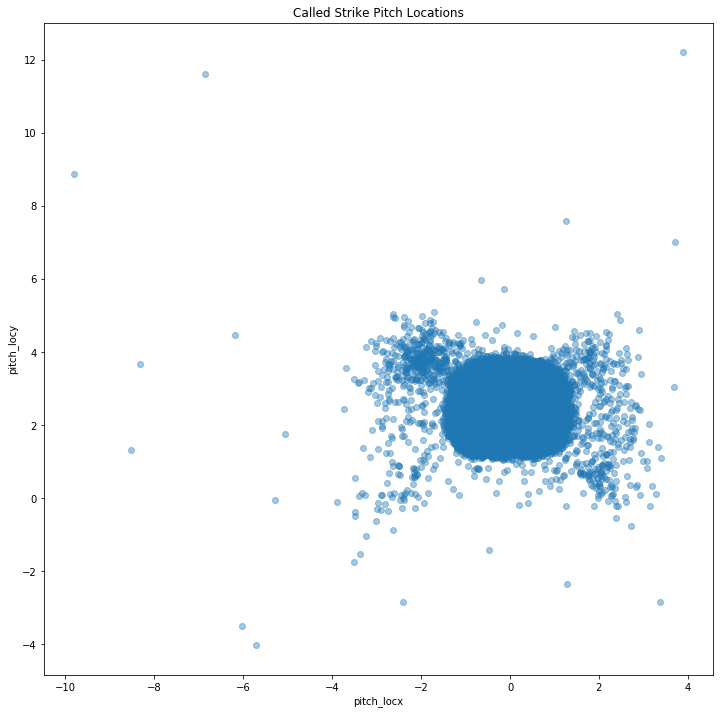

In [27]:
# Plot called strikes
_ = plt.figure(figsize=(12, 12))
_ = plt.scatter(called_strikes['pitch_locx'], called_strikes['pitch_locy'], alpha=0.4)
_ = plt.title('Called Strike Pitch Locations')
_ = plt.xlabel('pitch_locx')
_ = plt.ylabel('pitch_locy')

From the plot above, the strikezone seems to be localized to $-2 < $ ``pitch_locx`` $ < 2$ and $1 < $ ``pitch_locy`` $ < 4$ with some variance and outliers but for now, those outliers will be ignored. Next will be to investigate how ``pitch_locx`` values correlate to which side the batter is hitting to get a better understanding of what the values mean.

In [28]:
# Filter out left and right handed batters
batlefty_calls = called_df[called_df['batSide_isRight'] == 0]
batrighty_calls = called_df[called_df['batSide_isRight'] == 1]

# Filter out negative pitch_locx values
batlefty_calls_neg = batlefty_calls[batlefty_calls['pitch_locx'] < 0]
batrighty_calls_neg = batrighty_calls[batrighty_calls['pitch_locx'] < 0]

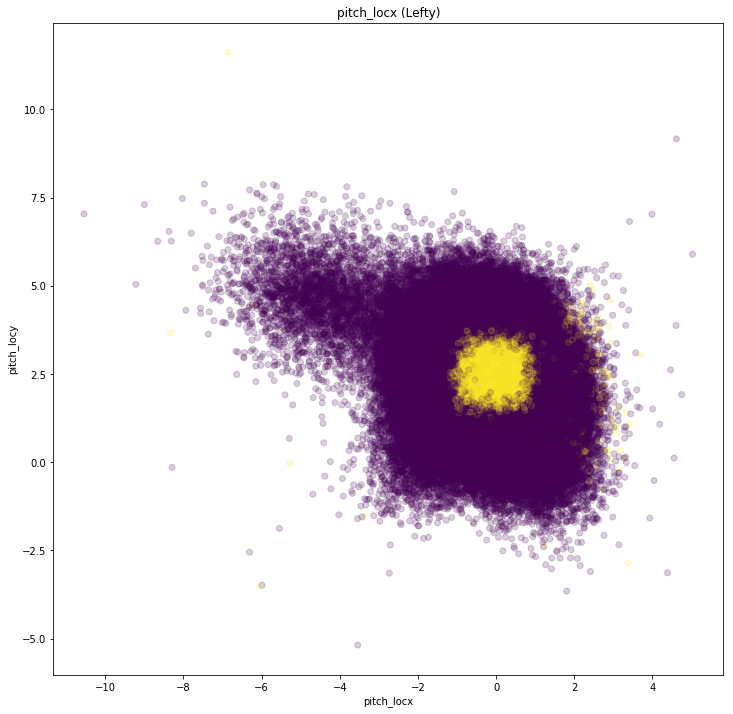

In [29]:
# Plot negative pitch_locx values for both batlefty_calls
_ = plt.figure(figsize=(12, 12))
_ = plt.scatter(batlefty_calls['pitch_locx'], batlefty_calls['pitch_locy'], c = batlefty_calls['call_C'], alpha = 0.2)
_ = plt.title('pitch_locx (Lefty)')
_ = plt.xlabel('pitch_locx')
_ = plt.ylabel('pitch_locy')

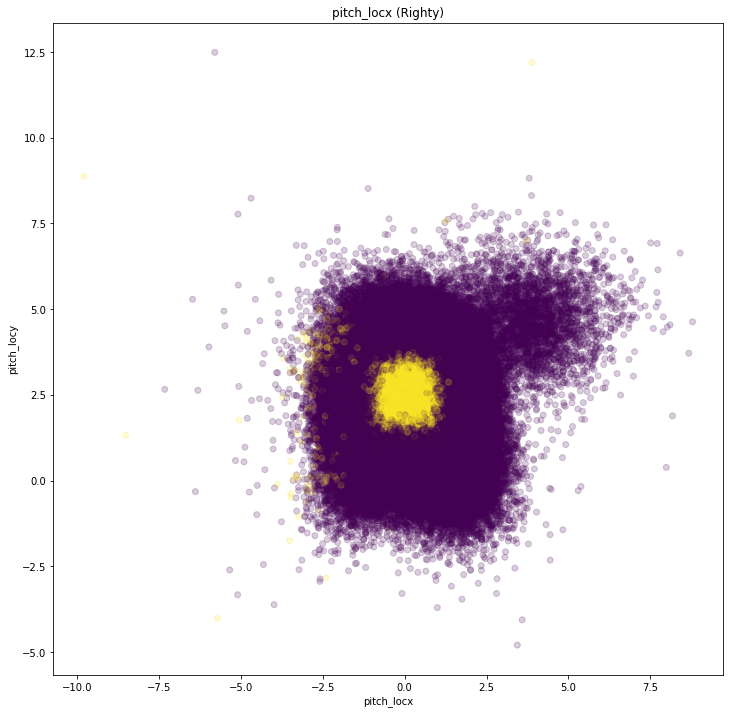

In [30]:
# Plot negative pitch_locx values for both batrighty_calls
_ = plt.figure(figsize=(12, 12))
_ = plt.scatter(batrighty_calls['pitch_locx'], batrighty_calls['pitch_locy'], c = batrighty_calls['call_C'], alpha = 0.2)
_ = plt.title('pitch_locx (Righty)')
_ = plt.xlabel('pitch_locx')
_ = plt.ylabel('pitch_locy')

From the plots above, it looks like negative ``pitch_locx`` doesn't depend on which side the batter is. However, it does give a perspective of where the pitches are located. In both plots, there's a cluster of pitches on opposite sides at the top of the main cluster when switching form left-handed batter to right-handed batters. We can infer from these plots then that the pitch locations are taken from the catcher's perspective instead of the pitcher's.

The next step towards categorizing pitch locations is to generalize the strikezone. Getting the general location, or edges, of the strikezone is important because it's a good indication of what locations umpires tend to call pitches and where batters should attempt swings at the ball.

As mentioned above, the strikezone seems to be localized to $-2 < $ ``pitch_locx`` $ < 2$ and $1 < $ ``pitch_locy`` $ < 4$ with some variances.

C:\Users\Curtis\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Curtis\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


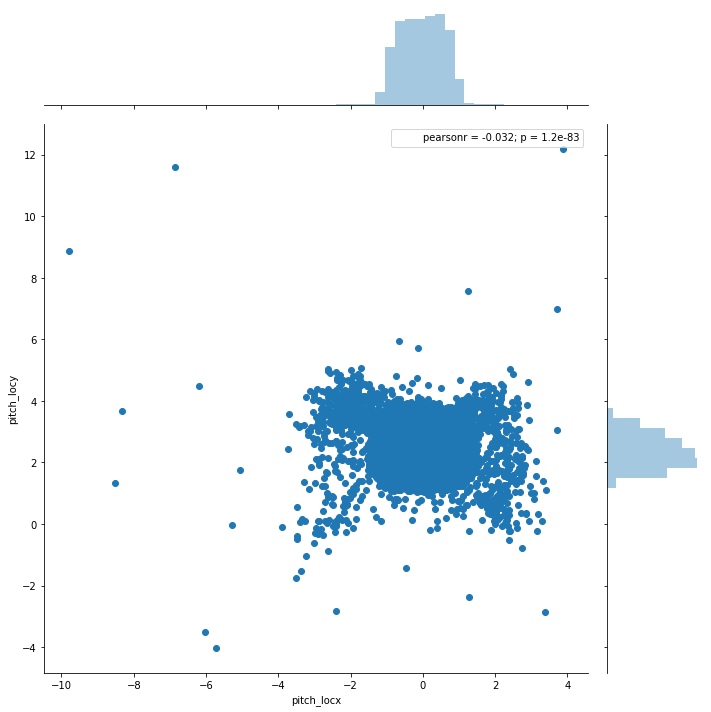

In [31]:
_ = sns.jointplot(x = 'pitch_locx', y = 'pitch_locy', data=called_strikes, size=10)

As it could be seen above, there's a lot of variance and outliers with these pitches but seem to be localized to the ranges mentioned above. Therefore, I'll be disregarding the outliers when trying to generalize the strikezone. I'll be taking the range of pitches $-4 < $ ``pitch_locx`` $ < 4$ and $0 < $ ``pitch_locy`` $ < 4$

In [32]:
# Remove outlying pitches
called_strikes_no_outliers = called_strikes[(called_strikes['pitch_locx'] > -4) &
                                           (called_strikes['pitch_locx'] < 4) &
                                           (called_strikes['pitch_locy'] > 0) &
                                           (called_strikes['pitch_locy'] < 4)]

In [33]:
# pitch_locx statistics & normal test
sz_width_stats = called_strikes_no_outliers['pitch_locx'].describe()
print(sz_width_stats)
normaltest(called_strikes_no_outliers['pitch_locx'])

count    358403.000000
mean         -0.024184
std           0.578586
min          -3.727377
25%          -0.500000
50%          -0.015000
75%           0.454000
max           3.698559
Name: pitch_locx, dtype: float64


NormaltestResult(statistic=16961.48977200845, pvalue=0.0)

In [34]:
# pitch_locy statistics & normal test
sz_height_stats = called_strikes_no_outliers['pitch_locy'].describe()
print(sz_height_stats)
normaltest(called_strikes_no_outliers['pitch_locy'])

count    358403.000000
mean          2.363715
std           0.521177
min           0.023847
25%           1.949000
50%           2.326000
75%           2.756000
max           3.999000
Name: pitch_locy, dtype: float64


NormaltestResult(statistic=22529.56143270064, pvalue=0.0)

Given that both ``pitch_locx`` and ``pitch_locy`` are normally distributed (determined by the significant ``normaltest`` p-values above), we can get the maximum and minimum width and height of the strikezone where 95% of called strikes lie. That's done by adding and subtracting two times the standard deviation from the mean.

In [35]:
# Set variables for edges of the strikezone
sz_top = sz_height_stats['mean'] + 2*sz_height_stats['std']
sz_bot = sz_height_stats['mean'] - 2*sz_height_stats['std']
sz_right = sz_width_stats['mean'] - 2*sz_width_stats['std']
sz_left = sz_width_stats['mean'] + 2*sz_width_stats['std']

print(sz_top, sz_bot, sz_right, sz_left)

3.406069929263573 1.321360904579162 -1.1813552200938393 1.1329879670758147


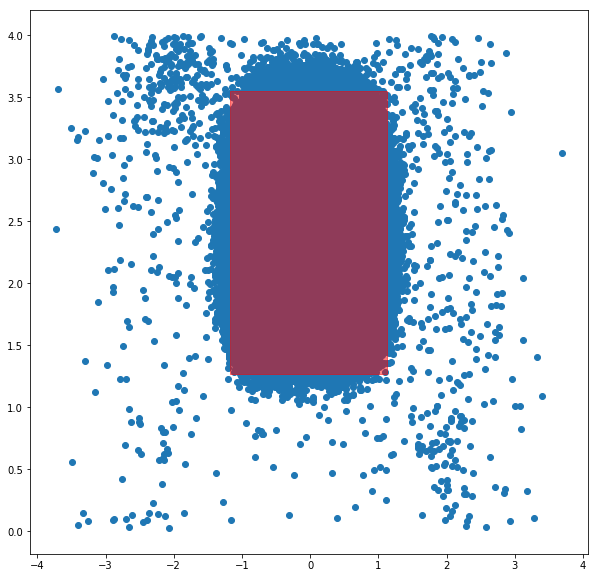

In [36]:
# Plot pitches with general strikezone
fig, ax = plt.subplots(figsize=(10, 10))
_ = ax.scatter(called_strikes_no_outliers['pitch_locx'], called_strikes_no_outliers['pitch_locy'])
_ = ax.axvspan(sz_right, sz_left, 
               ymin = sz_bot/4,
               ymax = sz_top/4,
               color='red', alpha=0.5)

As shown above in the shaded red area, the "strikezone" covers the corners of the cluster of called strikes. This is the area pitchers should aim for in the hopes of getting a called strike. Although there's still variance here and pitches that were called strikes outside the "strikezone", but that's possibly due to the umpire calling the game and their error, but generally speaking, if a pitcher threw a pitch in the "strikezone", it'll most likely be called a strike and that's what the goal was.

Next is to classify the location of the pitch depending where it's thrown and if it's a ball or strike.

In [37]:
# Break strikezone into 9 zones
sz_height = sz_top - sz_bot
sz_width = sz_left - sz_right

sz_right_third = sz_right + sz_width/3
sz_left_third = sz_left - sz_width/3
sz_top_third = sz_top - sz_height/3
sz_bot_third = sz_bot + sz_height/3

In [ ]:
print(sz)

In [38]:
# Categorize each pitch location and create a new column in df
df['ball_up_right'] = np.where((df['pitch_locx'] < sz_right) & (df['pitch_locy'] > sz_top), 1, 0)
df['ball_up'] = np.where((df['pitch_locx'] > sz_right) & (df['pitch_locx'] < sz_left) & (df['pitch_locy'] > sz_top), 1, 0)
df['ball_up_left'] = np.where((df['pitch_locx'] > sz_left) & (df['pitch_locy'] > sz_top), 1, 0)
df['ball_right'] = np.where((df['pitch_locx'] < sz_right) & (df['pitch_locy'] < sz_top) & (df['pitch_locy'] > sz_bot), 1, 0)
df['ball_left'] = np.where((df['pitch_locx'] > sz_left) & (df['pitch_locy'] < sz_top) & (df['pitch_locy'] > sz_bot), 1, 0)
df['ball_down_right'] = np.where((df['pitch_locx'] < sz_right) & (df['pitch_locy'] < sz_bot), 1, 0)
df['ball_down'] = np.where((df['pitch_locx'] > sz_right) & (df['pitch_locx'] < sz_left) & (df['pitch_locy'] < sz_bot), 1, 0)
df['ball_down_left'] = np.where((df['pitch_locx'] > sz_left) & (df['pitch_locy'] < sz_bot), 1, 0)

df['strike_up_right'] = np.where((df['pitch_locx'] >= sz_right) & (df['pitch_locx'] < sz_right_third) & (df['pitch_locy'] <= sz_top) & (df['pitch_locy'] > sz_top_third), 1, 0)
df['strike_up'] = np.where((df['pitch_locx'] >= sz_right_third) & (df['pitch_locx'] < sz_left_third) & (df['pitch_locy'] <= sz_top) & (df['pitch_locy'] > sz_top_third), 1, 0)
df['strike_up_left'] = np.where((df['pitch_locx'] >= sz_left_third) & (df['pitch_locx'] <= sz_left) & (df['pitch_locy'] <= sz_top) & (df['pitch_locy'] > sz_top_third), 1, 0)
df['strike_right'] = np.where((df['pitch_locx'] >= sz_right) & (df['pitch_locx'] < sz_right_third) & (df['pitch_locy'] <= sz_top_third) & (df['pitch_locy'] > sz_bot_third), 1, 0)
df['strike_mid'] = np.where((df['pitch_locx'] >= sz_right_third) & (df['pitch_locx'] < sz_left_third) & (df['pitch_locy'] <= sz_top_third) & (df['pitch_locy'] > sz_bot_third), 1, 0)
df['strike_left'] = np.where((df['pitch_locx'] >= sz_left_third) & (df['pitch_locx'] <= sz_left) & (df['pitch_locy'] <= sz_top_third) & (df['pitch_locy'] > sz_bot_third), 1, 0)
df['strike_down_right'] = np.where((df['pitch_locx'] >= sz_right) & (df['pitch_locx'] < sz_right_third) & (df['pitch_locy'] <= sz_bot_third) & (df['pitch_locy'] >= sz_bot), 1, 0)
df['strike_down'] = np.where((df['pitch_locx'] >= sz_right_third) & (df['pitch_locx'] < sz_left_third) & (df['pitch_locy'] <= sz_bot_third) & (df['pitch_locy'] >= sz_bot), 1, 0)
df['strike_down_left'] = np.where((df['pitch_locx'] >= sz_left_third) & (df['pitch_locx'] <= sz_left) & (df['pitch_locy'] <= sz_bot_third) & (df['pitch_locy'] >= sz_bot), 1, 0)

In [39]:
df.head()

,game_id,batSide_code,batSide_des,batter,batter_id,call_des,count_balls,count_strikes,inning_num,inning_top_bot,...,ball_down_left,strike_up_right,strike_up,strike_up_left,strike_right,strike_mid,strike_left,strike_down_right,strike_down,strike_down_left
0,413661,L,Left,Matt Carpenter,572761,Called Strike,0,0,1,top,...,0,0,0,1,0,0,0,0,0,0
1,413661,L,Left,Matt Carpenter,572761,Swinging Strike,0,1,1,top,...,0,0,0,0,0,1,0,0,0,0
2,413661,L,Left,Matt Carpenter,572761,Foul,0,2,1,top,...,0,1,0,0,0,0,0,0,0,0
3,413661,L,Left,Matt Carpenter,572761,Ball,0,2,1,top,...,0,0,0,0,0,0,0,0,0,0
4,413661,L,Left,Matt Carpenter,572761,Ball,1,2,1,top,...,0,0,0,0,0,0,0,0,0,0


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2129403 entries, 0 to 2134072
Data columns (total 60 columns):
game_id                          int64
batSide_code                     object
batSide_des                      object
batter                           object
batter_id                        int64
call_des                         object
count_balls                      int64
count_strikes                    int64
inning_num                       int64
inning_top_bot                   object
pitchHand_code                   object
pitchHand_des                    object
pitch_locx                       float64
pitch_locy                       float64
pitch_speed                      float64
pitch_type                       object
pitcher                          object
pitcher_id                       int64
is_out                           int64
pitchHand_isRight                int32
batSide_isRight                  int32
pitch_type_Changeup              uint8
pitch_type_Cur

### Combining Columns

Next would be to reorder the columns so that predictor variables are grouped consecutively next to target variables.

In [41]:
# Get column names as a list
cols = df.columns.tolist()

In [42]:
# Reorder the column names
detail_cols = ['game_id', 'batSide_code', 'batSide_des', 'batter', 'batter_id', 'call_des', 'inning_top_bot', 'pitchHand_code',
               'pitchHand_des', 'pitch_type', 'pitcher', 'pitcher_id']
predictor_cols = ['count_balls', 'count_strikes', 'inning_num', 'pitch_locx', 'pitch_locy', 'pitch_speed', 'pitchHand_isRight',
                  'batSide_isRight', 'pitch_type_Changeup', 'pitch_type_Curveball', 'pitch_type_Cutter', 'pitch_type_Eephus',
                  'pitch_type_Fastball', 'pitch_type_Forkball', 'pitch_type_Four-Seam Fastball', 'pitch_type_Int. Ball',
                  'pitch_type_Knuckle Curve', 'pitch_type_Knuckleball', 'pitch_type_Pitchout', 'pitch_type_Screwball',
                  'pitch_type_Sinker', 'pitch_type_Slider', 'pitch_type_Splitter', 'pitch_type_Two-Seam Fastball',
                  'pitch_type_Unknown', 'ball_up_right', 'ball_up', 'ball_up_left', 'ball_right', 'ball_left', 'ball_down_right',
                 'ball_down', 'ball_down_left', 'strike_up_right', 'strike_up', 'strike_up_left', 'strike_right', 'strike_mid',
                 'strike_left', 'strike_down_right', 'strike_down', 'strike_down_left']
target_cols = ['call_B', 'call_C', 'call_F', 'call_H', 'call_S', 'is_out']

reorder_cols = detail_cols + predictor_cols + target_cols
df = df[reorder_cols]

In [43]:
# Export df to csv
df.to_csv('..\\Data\\all_pitches.csv', index=False)